# Analysis Notebook
1. Setup
2. Set up directory
3. Load logging file
4. Reverse-engineer dictionary
5. Plot
5a) Loss
5b) Train Accuracy
5c) Test Accuracy

# 1 - Setup

In [1]:
import matplotlib.pyplot as plt
import itertools
import copy
import warnings
import json
import numpy as np
import os
import math
import torch
%load_ext autoreload
%autoreload 2

# 2- Set up directory

In [46]:
# Load logging file

# when you called jupyter from ParlAI/:
path = '../data/models/convai2/'
folder = 'profilememory'
session_directory = os.path.join(path, folder)

#print(session_directory)
for root, dirs, files in os.walk(session_directory):
    for name in files:
        print(os.path.join(root, name))
    for name in dirs:
        print(os.path.join(root, name))
    print(root)
    print(dirs)
    print(files)

../data/models/convai2/profilememory/.built
../data/models/convai2/profilememory/profilememory.txt
../data/models/convai2/profilememory/profilememory_convai2.dict
../data/models/convai2/profilememory/profilememory_convai2_model
../data/models/convai2/profilememory
[]
['.built', 'profilememory.txt', 'profilememory_convai2.dict', 'profilememory_convai2_model']


# 3- Load Data

In [56]:
#results = {}
#loggings = 

file = "profilememory.txt"

with open ((path + folder + "/" + file), 'rt') as in_file:  # Open file lorem.txt for reading of text data.
    log = in_file.read()# Read the entire file into a variable named contents.
    print(log) # Print contents.


/home/team_roboy/ss18_showmaster/ParlAI/data/models/glove_vectors/glove.840B.300d.zip: 0.00B [00:00, ?B/s]
/home/team_roboy/ss18_showmaster/ParlAI/data/models/glove_vectors/glove.840B.300d.zip:   0%|          | 8.19k/2.18G [00:00<12:58:44, 46.6kB/s]
/home/team_roboy/ss18_showmaster/ParlAI/data/models/glove_vectors/glove.840B.300d.zip:   0%|          | 221k/2.18G [00:00<9:10:56, 65.8kB/s]  
/home/team_roboy/ss18_showmaster/ParlAI/data/models/glove_vectors/glove.840B.300d.zip:   0%|          | 958k/2.18G [00:00<6:27:13, 93.6kB/s]
/home/team_roboy/ss18_showmaster/ParlAI/data/models/glove_vectors/glove.840B.300d.zip:   0%|          | 3.26M/2.18G [00:00<4:31:14, 134kB/s]
/home/team_roboy/ss18_showmaster/ParlAI/data/models/glove_vectors/glove.840B.300d.zip:   0%|          | 10.1M/2.18G [00:00<3:09:25, 191kB/s]
/home/team_roboy/ss18_showmaster/ParlAI/data/models/glove_vectors/glove.840B.300d.zip:   1%|          | 21.7M/2.18G [00:00<2:11:59, 272kB/s]
/home/team_roboy/ss18_showmaster/ParlAI/da

# 4 - Create Dictionary

In [62]:
# reverse engineer logged shell output from string to dictionary
log_dict = dict()
time_between_validations = 360

# needed to extract relevant entreis form string
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""


with open ((path + folder + "/" + file), 'rt') as fp: 
    line = fp.readline()
    cnt = 1
    dict_cnt = 1
    val_time = time_between_validations
    while line:
        teststring = line.strip()
        
        # filter for relevant lines
        if (teststring[0:7] == '[ time:') == True:
            
            # extract relevant entries form string
            time = float(find_between( teststring, "time:", "s " ))   
            total_exs = float(find_between( teststring, "total_exs:", " " ))
            #time_left = float(find_between( teststring, "time_left:", "s " ))
            
            exs = float(find_between( teststring, "'exs': ", ", " ))
            #mean_rank = float(find_between( teststring, "'mean_rank':", ", " ))
            accuracy = float(find_between( teststring, "'accuracy': ", ", " ))
            try:
                train_f1 = float(find_between( teststring, "'f1': ", ", " ))
            except:
                train_f1 = float(find_between( teststring, "'f1': ", "}" ))
            try:
                train_loss = float(find_between( teststring, "'loss': ", ", " ))
            except: 
                train_loss = None
            try:
                train_ppl = float(find_between( teststring, "'ppl': ", "}" ))
            except:
                train_ppl = None
            
            #total = float(find_between( teststring, "'total': ", ", 'accuracy':" ))
            #accuracy = float(find_between( teststring, "'accuracy': ", ", 'f1':" ))
            #f1 = float(find_between( teststring, "'f1': ", ", 'loss'" ))
            #loss = float(find_between( teststring, "'loss': ", ", 'ppl'" ))
            #ppl = float(find_between( teststring, "'ppl': ", "}" ))                  
            
            #save to dictionary
            log_dict[dict_cnt] = {'time': time, 'total_exs': total_exs, 'exs': exs, \
                                  'train_accuracy': accuracy, 'val_accuracy': None, \
                                  'train_f1': train_f1, 'val_f1:': None,\
                                  'train_loss': train_loss, 'val_loss': None, \
                                  'hits@1': None, 'hits@5': None, 'hits@10': None, 'hits@100': None,\
                                  'train_ppl': train_ppl}

            #{'time': time, 'parleys': parleys, 'time_left': time_left,'total': total, 'mean_rank': mean_rank, 'loss': loss}
            dict_cnt += 1
        
        # log validations every x seconds
        elif (teststring[0:7] == 'valid:{') == True:
            exs = float(find_between( teststring, "'exs': ", ", " ))
            accuracy = float(find_between( teststring, "'accuracy': ", ", " ))
            val_f1 = float(find_between( teststring, "'f1': ", ", " ))
            hits1 = float(find_between( teststring, "'hits@1': ", ", " ))
            hits5 = float(find_between( teststring, "'hits@5': ", ", " ))
            hits10 = float(find_between( teststring, "'hits@10': ", ", " ))
            hits100 = float(find_between( teststring, "'hits@100': ", ", " ))
            val_loss = float(find_between( teststring, "'loss': ", ", " ))
            val_ppl = float(find_between( teststring, "'ppl': ", "}" ))
            log_dict[dict_cnt] = {'time': val_time, 'total_exs': None, 'exs': exs, 
                                  'train_accuracy': None, 'val_accuracy': accuracy, \
                                  'train_f1': None, 'val_f1': val_f1, \
                                  'train_loss': None, 'val_loss': val_loss, \
                                  'hits@1': hits1, 'hits@5': hits5, 'hits@10': hits10, 'hits@100': hits100, \
                                  'val_ppl': val_ppl}
            val_time += time_between_validations
            dict_cnt += 1
        
        line = fp.readline()
        cnt += 1
print(log_dict)

{1: {'time': 5.0, 'total_exs': 480.0, 'exs': 480.0, 'train_accuracy': 0.0, 'val_accuracy': None, 'train_f1': 0.05348, 'val_f1:': None, 'train_loss': None, 'val_loss': None, 'hits@1': None, 'hits@5': None, 'hits@10': None, 'hits@100': None, 'train_ppl': None}, 2: {'time': 10.0, 'total_exs': 960.0, 'exs': 480.0, 'train_accuracy': 0.0, 'val_accuracy': None, 'train_f1': 0.07363, 'val_f1:': None, 'train_loss': None, 'val_loss': None, 'hits@1': None, 'hits@5': None, 'hits@10': None, 'hits@100': None, 'train_ppl': None}, 3: {'time': 15.0, 'total_exs': 1472.0, 'exs': 512.0, 'train_accuracy': 0.0, 'val_accuracy': None, 'train_f1': 0.08294, 'val_f1:': None, 'train_loss': None, 'val_loss': None, 'hits@1': None, 'hits@5': None, 'hits@10': None, 'hits@100': None, 'train_ppl': None}, 4: {'time': 21.0, 'total_exs': 1984.0, 'exs': 512.0, 'train_accuracy': 0.0, 'val_accuracy': None, 'train_f1': 0.12, 'val_f1:': None, 'train_loss': None, 'val_loss': None, 'hits@1': None, 'hits@5': None, 'hits@10': None,

# 5 - Plots

In [49]:
### plot parameters
#fontsizes
import matplotlib.patches as mpatches

fs_title = 24
fs_ax_labels = 20
fs_tick_labels=18
fs_legend = 20

is_final_plot = True

# 5.1 - LOSS

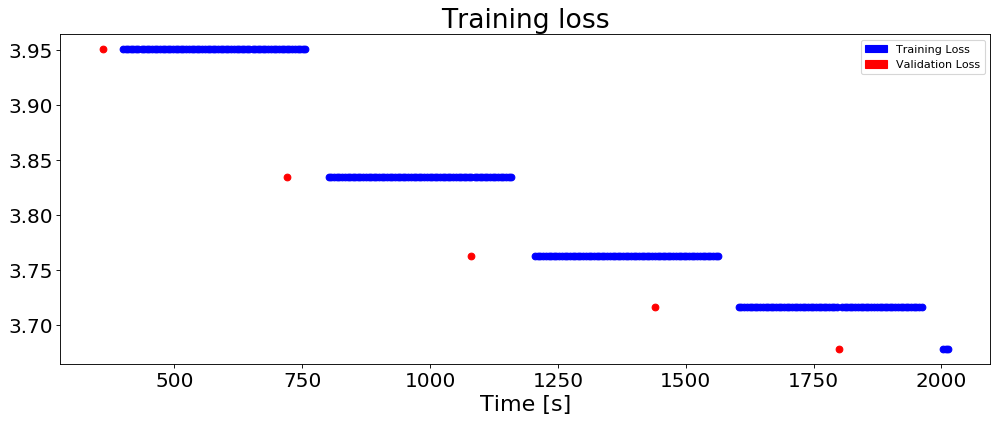

In [63]:
# Plot loss

fig_trloss=plt.figure(dpi= 80, facecolor='w', edgecolor='k')

plot = plt.subplot(2, 1, 1)
plt.title('Training loss',fontsize= fs_title)

for i in range(1,len(log_dict)):
    time = log_dict[i]['time']
    try:
        train_loss = log_dict[i]['train_loss']
        plt.plot(time, train_loss, marker = 'o', color = 'blue')
    except:
        pass
    try:
        val_loss = log_dict[i]['val_loss']
        plt.plot(time, val_loss, marker = 'o', color = 'red')
    except:
        pass

plt.xlabel('Time [s]', fontsize= fs_ax_labels)

#plt.legend(loc='best', fontsize = fs_legend)
plt.gcf().set_size_inches(15, 12)
plt.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
blue_patch = mpatches.Patch(color='blue', label='Training Loss')
red_patch = mpatches.Patch(color='red', label='Validation Loss')
plt.legend(handles=[blue_patch, red_patch])
plt.show()

# 5.2 - Accuracy

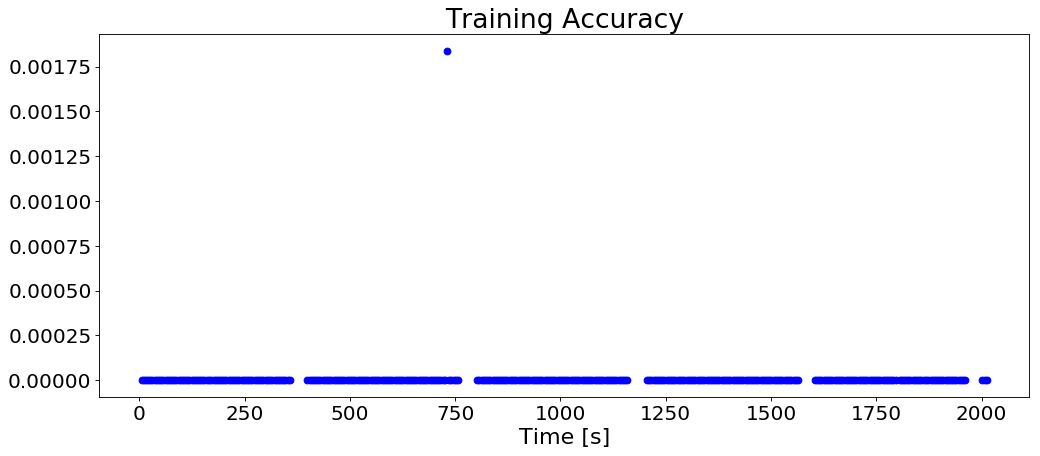

In [64]:
# Plot training accuracy

fig_tr_acc=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_tr_acc.add_subplot(111)

#plot = plt.subplot(2, 1, 1)
plt.title('Training Accuracy', fontsize=fs_title)


for i in range(1,len(log_dict)):
    time = log_dict[i]['time']
    acc = log_dict[i]['train_accuracy']
    if acc != None:
        plt.plot(time, acc, marker = 'o', color = 'blue')

        
plt.xlabel('Time [s]', fontsize = fs_ax_labels)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

# 5.3 - Hits@X

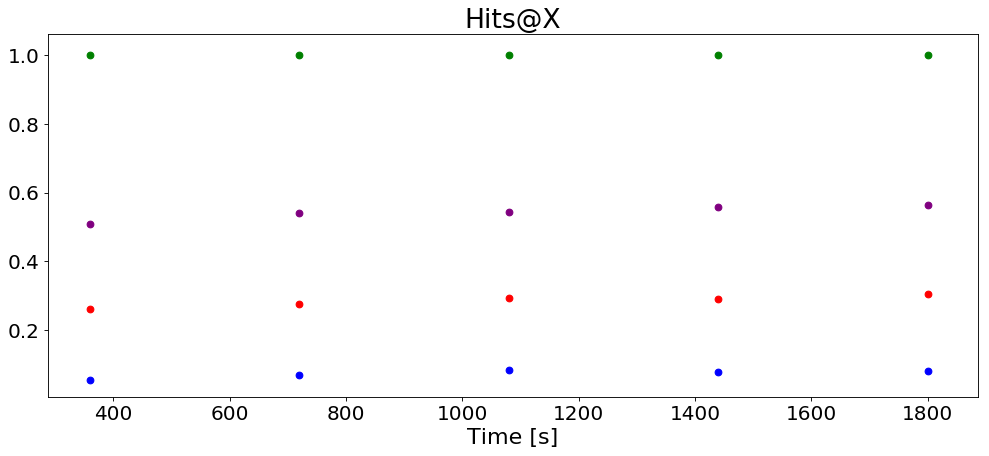

In [65]:
# Plot training accuracy

fig_trhits=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_trhits.add_subplot(111)

#plot = plt.subplot(2, 1, 1)
plt.title('Hits@X', fontsize=fs_title)

for i in range(1,len(log_dict)):
    time = log_dict[i]['time']
    try:
        hits1 = log_dict[i]['hits@1']
        hits5 = log_dict[i]['hits@5']
        hits10 = log_dict[i]['hits@10']
        hits100 = log_dict[i]['hits@100']
        plt.scatter(time, hits1, marker = 'o', color = 'blue')
        plt.scatter(time, hits5, marker = 'o', color = 'red')
        plt.scatter(time, hits10, marker = 'o', color = 'purple')
        plt.scatter(time, hits100, marker = 'o', color = 'green')
    except:
        pass
        
plt.xlabel('Time [s]', fontsize = fs_ax_labels)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

# 5.4 - F1

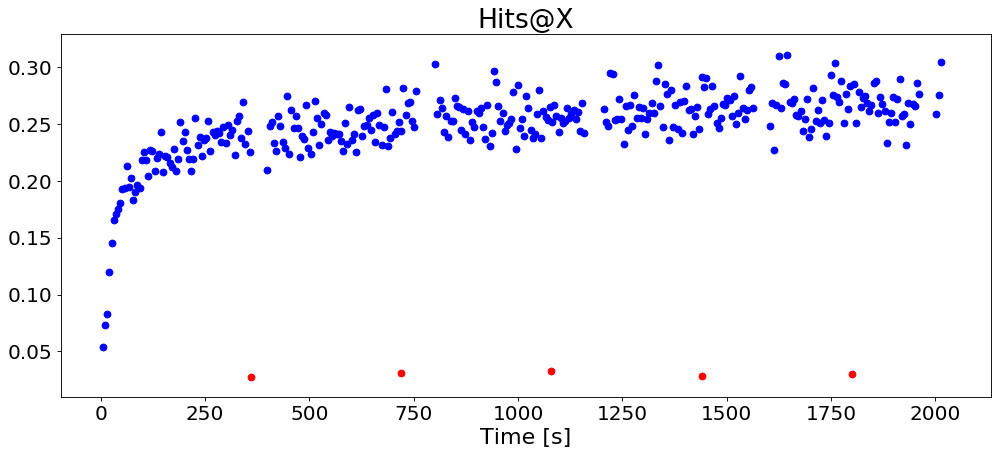

In [66]:
# Plot training accuracy

fig_trhits=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_trhits.add_subplot(111)

#plot = plt.subplot(2, 1, 1)
plt.title('Hits@X', fontsize=fs_title)

for i in range(1,len(log_dict)):
    time = log_dict[i]['time']
    try:
        train_f1 = log_dict[i]['train_f1']
        plt.scatter(time, train_f1, marker = 'o', color = 'blue')
    except:
        pass
    try:
        val_f1 = log_dict[i]['val_f1']
        plt.scatter(time, val_f1, marker = 'o', color = 'red')
    except:
        pass
        
plt.xlabel('Time [s]', fontsize = fs_ax_labels)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

No handles with labels found to put in legend.


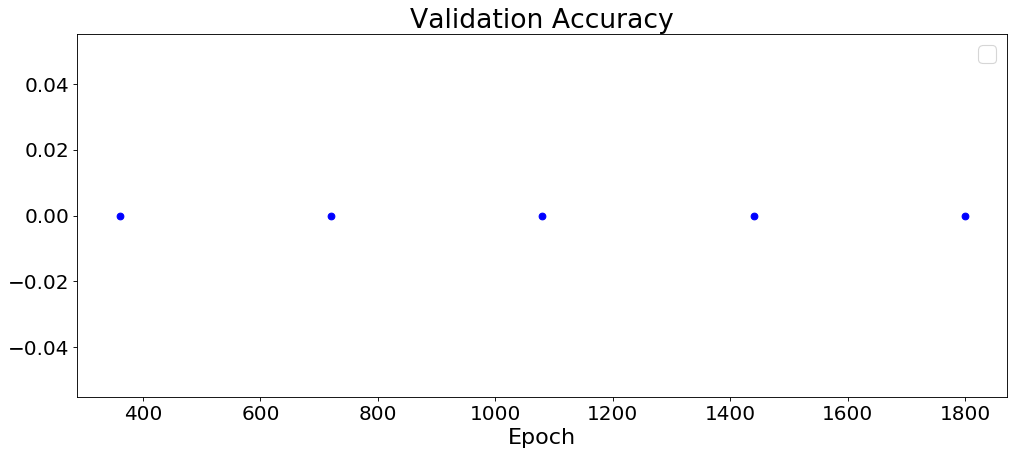

In [67]:
# Plot valdiation accuracy

fig_val_acc=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_val_acc.add_subplot(111)

plt.title('Validation Accuracy', fontsize=fs_title)


for i in range(1,len(log_dict)):
    try:
        time = log_dict[i]['time']
        acc = log_dict[i]['val_accuracy']
        if acc != None:
            plt.plot(time, acc, marker = 'o', color = 'blue')
    except:
        pass

plt.xlabel('Epoch', fontsize = fs_ax_labels)
plt.legend(loc='best', fontsize= fs_legend)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

No handles with labels found to put in legend.


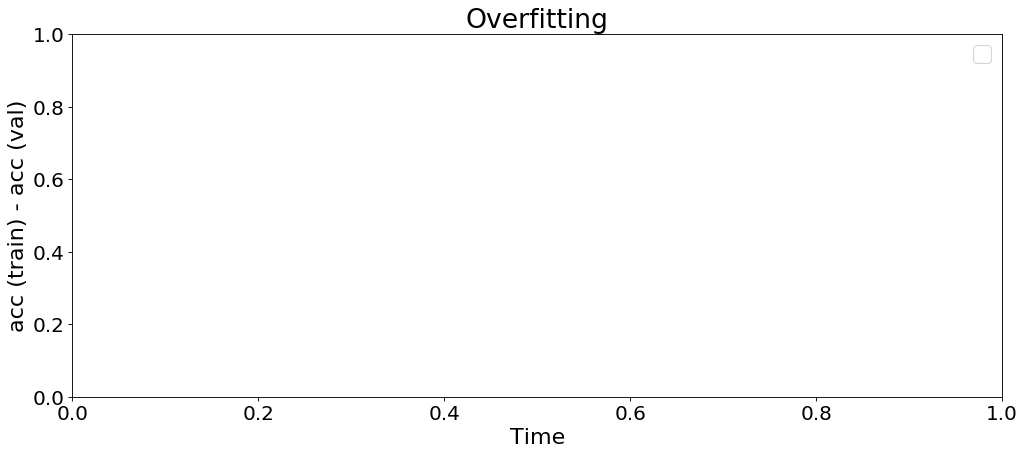

In [68]:
### Plot overfitting curves (difference between train_acc and small_val_acc)

fig_overfitting=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_overfitting.add_subplot(111)

plt.title('Overfitting', fontsize=fs_title)

for i in range(1,len(log_dict)):
    try:
        time = log_dict[i]['time']
        overfit = abs(log_dict[i]['val_accuracy']-log_dict[i]['train_accuracy'])

        at_end = overfitting[-1]
        print("\tAverage:%.3f\tOverfitting at end:%.3f" % (average, at_end))
        plt.plot(time, acc, marker = 'o')
    except:
        pass
    
plt.xlabel('Time', fontsize=fs_ax_labels)
plt.ylabel('acc (train) - acc (val)', fontsize=fs_ax_labels)
plt.legend(loc='best', fontsize=fs_legend)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)

plt.show()

In [ ]:
### Save graphics
path = '/'
#fig_trloss.savefig(path+'tr_loss.pdf',bbox_inches='tight', format='pdf')
# fig_val_acc.savefig(path+'val_acc.pdf',bbox_inches='tight', format='pdf')
# fig_tr_acc.savefig(path+'tr_acc.pdf',bbox_inches='tight', format='pdf')

fig_asl_model.savefig(path+'acc_asl.pdf',bbox_inches='tight', format='pdf')
#fig_combi_model.savefig(path+'acc_combi.pdf',bbox_inches='tight', format='pdf')

#fig_overfitting.savefig(path+'overfitting.pdf',bbox_inches='tight', format='pdf')
#fig_3acc.savefig(path+'3_accuracies.pdf',bbox_inches='tight', format='pdf')
#fig_val_matrix.savefig(path+'val_conf_matrix.pdf',bbox_inches='tight', format='pdf')
#fig_test_matrix.savefig(path+'test_conf_matrix.pdf',bbox_inches='tight', format='pdf')

# X - other

In [ ]:
# extract from certain line
print(a[182])
teststring = a[182]
#time = 
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""
    
time = find_between( teststring, "time:", "s parleys:" )
parleys = find_between( teststring, "parleys:", " ] {" )
total = find_between( teststring, "'total': ", ", 'accuracy':" )
accuracy = find_between( teststring, "'accuracy': ", ", 'f1':" )
f1 = find_between( teststring, "'f1': ", ", 'loss'" )
loss = find_between( teststring, "'loss': ", ", 'ppl'" )
ppl = find_between( teststring, "'ppl': ", "}" )





print(time)
print(parleys)
print(total)
print(accuracy)
print(f1)
print(loss)
print(ppl)

#print(find_between( s, "time:", "s" ))
#print(find_between_r( s, "time:", "s" ))